# 1. Defining Problem

In [ ]:
# #set a working directory on the google drive
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks/pestsens/

In [9]:
pip install rioxarray

  Using cached rioxarray-0.14.1-py3-none-any.whl (53 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.3/994.3 kB 4.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
#pip install rasterio rasterstats earthpy scikit-plot
!pip3 install scikit-plot

  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)


In [1]:
#Load the libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.plot import plotting_extent
import geopandas as gpd
#import rasterstats as rs
import earthpy as et
import earthpy.plot as ep
import rasterio



# #Import machine learning libraries
# from imblearn.over_sampling import SMOTE
import scikitplot as skplt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder



In [2]:
src=rasterio.open("/home/drdc/Documents/repos/pestsens/1_orginal/S2_srw.tif")
src

<open DatasetReader name='/home/drdc/Documents/repos/pestsens/1_orginal/S2_srw.tif' mode='r'>

In [3]:

#Load the dataset
train_points=gpd.read_file("/home/drdc/Documents/repos/pestsens/1_orginal/rwanda_points.shp")
s2=rxr.open_rasterio("/home/drdc/Documents/repos/pestsens/1_orginal/S2_srw.tif")
df= pd.read_csv('/home/drdc/Documents/repos/pestsens/2_processed/df.csv', delimiter=',')


In [76]:
s2.shape

(11, 881, 654)

In [4]:
image_array = s2.values
first_band_array = image_array[0]


In [7]:
first_band_array.shape

(881, 654)

In [5]:
import rasterio
import numpy as np

# Path to the Sentinel-2 image file
image_path = "/home/drdc/Documents/repos/pestsens/1_orginal/S2_srw.tif"

# Open the image using rasterio
with rasterio.open(image_path) as dataset:
    # Read the image bands (assuming a 3-band image)
    red = dataset.read(1)
    green = dataset.read(2)
    blue = dataset.read(3)

    # Stack the bands together
    stacked = np.stack([red, green, blue], axis=2)

# Convert the stacked image to a 2D NumPy array
array_2d = stacked.reshape(-1, stacked.shape[2])

# Print the shape of the 2D array
print(array_2d.shape)


(576174, 3)


In [10]:
array_2d

array([[0.1743, 0.2543, 0.1011],
       [0.1743, 0.2543, 0.1011],
       [0.1928, 0.2613, 0.1011],
       ...,
       [0.1343, 0.1829, 0.1012],
       [0.1343, 0.1829, 0.1012],
       [0.1323, 0.1773, 0.1013]])

In [55]:
stacked.shape

(881, 654, 3)

In [33]:
type(array_2d)

numpy.ndarray

In [79]:
# read all bands of the dataset into 3-dimensional array stack - (band, row, column)
stack = src.read() 
print(stack.shape)

(11, 881, 654)


In [16]:
img = src.read()   # load our original input file bands to a numby array stack
profile = src.profile  # the copy the profile of the original GeoTIFF input file
with rasterio.io.MemoryFile() as memfile:
    with memfile.open(**profile) as dst:
        for i in range(0, src.count):
            dst.write(img[i], i+1)
    dataset = memfile.open()

In [17]:
from rasterio.plot import reshape_as_raster, reshape_as_image
imx=dataset.read()
print(imx.shape)  # (bands, rows, cols)
reshaped_img = reshape_as_image(imx)
print(reshaped_img.shape)  # (rows, cols, bands)

(11, 881, 654)
(881, 654, 11)


In [11]:
train_points.head()

,category,geometry
0,forest,POINT (29.05868 -2.42512)
1,tea,POINT (29.06158 -2.42884)
2,tea,POINT (29.06205 -2.42944)
3,tea,POINT (29.06232 -2.43084)
4,tea,POINT (29.06508 -2.43202)


In [12]:
train_points.index= range(len(train_points))

In [13]:
coords = [(x,y) for x, y in zip(train_points.geometry.x, train_points.geometry.y)]  # Create list of point coordinates
coords[0:5]

[(29.05868427375566, -2.4251230961172885),
 (29.061584078857702, -2.4288439506871766),
 (29.062051082353786, -2.4294390851063747),
 (29.06231998869901, -2.4308400955946285),
 (29.06508154727875, -2.4320151910342345)]

In [14]:
bands= list(src.descriptions)      # Read all bands together
bands

['B12', 'B11', 'B10', 'B9', 'B8', 'B7', 'B6', 'B5', 'B4', 'B3', 'B2']

In [18]:
#Sample the each band of raster dataset at each point in the coordinate list
train_points['Raster_Value'] = [x for x in dataset.sample(coords)]   # all band values are saved as a list in the Raster Value column 
train_points.head()

,category,geometry,Raster_Value
0,forest,POINT (29.05868 -2.42512),"[0.1601, 0.2375, 0.1011, 0.1641, 0.3235, 0.329..."
1,tea,POINT (29.06158 -2.42884),"[0.1669, 0.2689, 0.1011, 0.1912, 0.4362, 0.444..."
2,tea,POINT (29.06205 -2.42944),"[0.1992, 0.2977, 0.1011, 0.1783, 0.3951, 0.403..."
3,tea,POINT (29.06232 -2.43084),"[0.159, 0.2605, 0.1011, 0.2002, 0.4599, 0.4679..."
4,tea,POINT (29.06508 -2.43202),"[0.1599, 0.2598, 0.1011, 0.1958, 0.452, 0.4589..."


In [19]:
# Unpack the Raster Value column to separate column for each band - band names were retrieved with snappy and are now usef as column names
train_points[bands] = pd.DataFrame(train_points['Raster_Value'].tolist(), index= train_points.index)  
train_points = train_points.drop(['Raster_Value'], axis=1)  # Remove Raster Value column

In [20]:
train_points.head()

,category,geometry,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2
0,forest,POINT (29.05868 -2.42512),0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921
1,tea,POINT (29.06158 -2.42884),0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945
2,tea,POINT (29.06205 -2.42944),0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955
3,tea,POINT (29.06232 -2.43084),0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932
4,tea,POINT (29.06508 -2.43202),0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938


In [21]:
train_points["x"]=train_points.geometry.x
train_points["y"]=train_points.geometry.y
train_points=train_points.drop(columns="geometry")
train_points.head()

,category,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,forest,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,tea,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,tea,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,tea,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,tea,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [33]:

train_points.head()

,category,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,forest,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,tea,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,tea,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,tea,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,tea,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [22]:
#create a copy of the data
df_clean=train_points.copy()

In [23]:
#look at the header of the cleaned data
df_clean.head()

,category,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,forest,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,tea,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,tea,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,tea,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,tea,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [24]:
# Give the categorical colum a meaningfull name 
df_clean.rename(columns={"category":"class"},inplace=True)

df_clean.head()

,class,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,forest,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,tea,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,tea,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,tea,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,tea,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [51]:
df_clean=df_clean.replace({"water":1, "forest":2, "tea":3, "other":4})
df_clean.head()

,class,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,2,0.1601,0.2375,0.1011,0.1641,0.3235,0.3295,0.2809,0.1820,0.1574,0.1754,0.1921,29.058684,-2.425123
1,3,0.1669,0.2689,0.1011,0.1912,0.4362,0.4444,0.3682,0.2084,0.1557,0.1918,0.1945,29.061584,-2.428844
2,3,0.1992,0.2977,0.1011,0.1783,0.3951,0.4032,0.3442,0.1986,0.1654,0.1853,0.1955,29.062051,-2.429439
3,3,0.1590,0.2605,0.1011,0.2002,0.4599,0.4679,0.3836,0.2054,0.1556,0.1934,0.1932,29.062320,-2.430840
4,3,0.1599,0.2598,0.1011,0.1958,0.4520,0.4589,0.3820,0.2033,0.1546,0.1904,0.1938,29.065082,-2.432015


In [29]:
print(df_clean.shape)

(800, 14)


In [61]:
#Create arrays for model development
array=df_clean.values
x=array[:,1:12]
y=array[:,0].astype(int)


# verify values
print(x[0:15])
print(y[0:5])

[[0.1601 0.2375 0.1011 0.1641 0.3235 0.3295 0.2809 0.182  0.1574 0.1754
  0.1921]
 [0.1669 0.2689 0.1011 0.1912 0.4362 0.4444 0.3682 0.2084 0.1557 0.1918
  0.1945]
 [0.1992 0.2977 0.1011 0.1783 0.3951 0.4032 0.3442 0.1986 0.1654 0.1853
  0.1955]
 [0.159  0.2605 0.1011 0.2002 0.4599 0.4679 0.3836 0.2054 0.1556 0.1934
  0.1932]
 [0.1599 0.2598 0.1011 0.1958 0.452  0.4589 0.382  0.2033 0.1546 0.1904
  0.1938]
 [0.1686 0.262  0.1011 0.1922 0.4086 0.4176 0.3554 0.1984 0.1537 0.1878
  0.1942]
 [0.1641 0.2637 0.1011 0.2019 0.4414 0.4527 0.3675 0.2025 0.1534 0.1887
  0.194 ]
 [0.1513 0.2355 0.1011 0.1839 0.3945 0.3881 0.3284 0.1826 0.1535 0.1769
  0.1915]
 [0.1898 0.2938 0.1011 0.1878 0.423  0.4172 0.3642 0.2129 0.161  0.1918
  0.1959]
 [0.1151 0.1319 0.1009 0.1438 0.1572 0.1876 0.1684 0.1652 0.1643 0.192
  0.2046]
 [0.108  0.1165 0.101  0.1173 0.1505 0.1605 0.1588 0.1529 0.1532 0.1818
  0.204 ]
 [0.1057 0.111  0.1009 0.1127 0.1446 0.153  0.153  0.1487 0.1533 0.1844
  0.2019]
 [0.1093 0.1203 0

In [63]:
y[0:10]

array([2, 3, 3, 3, 3, 3, 3, 2, 4, 1])

In [53]:
image_array[0:15]

array([[[0.1743, 0.1743, 0.1928, ..., 0.2264, 0.2003, 0.2003],
        [0.1876, 0.1876, 0.203 , ..., 0.2264, 0.2003, 0.2003],
        [0.1876, 0.1876, 0.203 , ..., 0.2395, 0.2019, 0.2019],
        ...,
        [0.1841, 0.1659, 0.1659, ..., 0.1286, 0.1286, 0.1364],
        [0.1925, 0.1835, 0.1835, ..., 0.1286, 0.1286, 0.1364],
        [0.1925, 0.1835, 0.1835, ..., 0.1343, 0.1343, 0.1323]],

       [[0.2543, 0.2543, 0.2613, ..., 0.3114, 0.2852, 0.2852],
        [0.2569, 0.2569, 0.2619, ..., 0.3114, 0.2852, 0.2852],
        [0.2569, 0.2569, 0.2619, ..., 0.325 , 0.2842, 0.2842],
        ...,
        [0.2861, 0.2682, 0.2682, ..., 0.172 , 0.172 , 0.1835],
        [0.2945, 0.2833, 0.2833, ..., 0.172 , 0.172 , 0.1835],
        [0.2945, 0.2833, 0.2833, ..., 0.1829, 0.1829, 0.1773]],

       [[0.1011, 0.1011, 0.1011, ..., 0.1011, 0.1012, 0.1012],
        [0.1011, 0.1011, 0.1011, ..., 0.1011, 0.1012, 0.1012],
        [0.1011, 0.1011, 0.1011, ..., 0.1011, 0.1011, 0.1011],
        ...,
        [0.1

In [64]:
#create a validation set to evaluate the model
#Evaluate Algorithms: Baseline
# Test options and evaluation metric
num_folds=10
seed=7
scoring='accuracy'
val_size=0.20
seed=7
x_train, x_val, y_train,y_val=train_test_split(x,y,test_size=val_size, random_state=seed)

In [ ]:
# y_val.value_counts()

In [27]:
# Spot-Check Algorithms
models=[]
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('NB',GaussianNB()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('SVC',SVC()))

# evaluate each model in turn
results=[]
names=[]
for name, model in models:
    kfold=KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,x_train,y_train,cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(name,'=', round(cv_results.mean(),2),'±',round(cv_results.std(),2))


LR = 0.87 ± 0.04
LDA = 0.9 ± 0.03
KNN = 0.9 ± 0.04
NB = 0.88 ± 0.03
CART = 0.87 ± 0.04
SVC = 0.89 ± 0.03


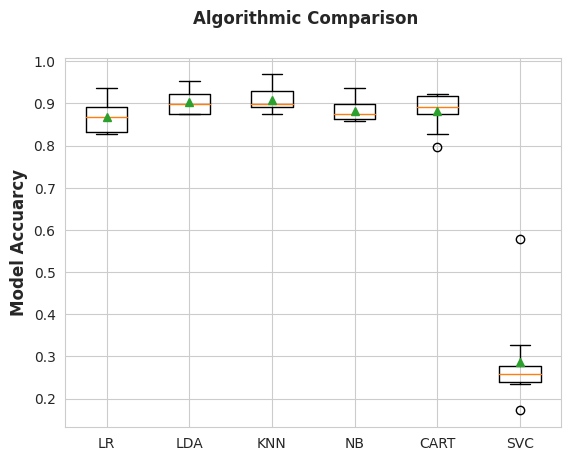

In [36]:
# Compare Algorithms
sns.set_style("whitegrid")
fig=plt.figure()
fig.suptitle('Algorithmic Comparison', size=12, weight="bold")
ax = fig.add_subplot(111)
plt.boxplot(results,labels=names, showmeans=True)
ax.set_xticklabels(names)
plt.ylabel("Model Accuarcy",size=12, weight="bold")
plt.show()

In [65]:
# ensembles
scoring='accuracy'
ensembles=[]
ensembles.append(('AB',AdaBoostClassifier()))
ensembles.append(('GBM',GradientBoostingClassifier()))
ensembles.append(('RF',RandomForestClassifier()))
ensembles.append(('ET',ExtraTreesClassifier()))

results_ens=[]
names_ens=[]
for name, model in ensembles:
    kfold=KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    cv_results=cross_val_score(model,x_train,y_train,cv=kfold, scoring=scoring,n_jobs=14)
    results_ens.append(cv_results)
    names_ens.append(name)
    print(name,'=', round(cv_results.mean(),2),'±',round(cv_results.std(),2))

AB = 0.77 ± 0.1
GBM = 0.92 ± 0.02
RF = 0.91 ± 0.02
ET = 0.91 ± 0.03


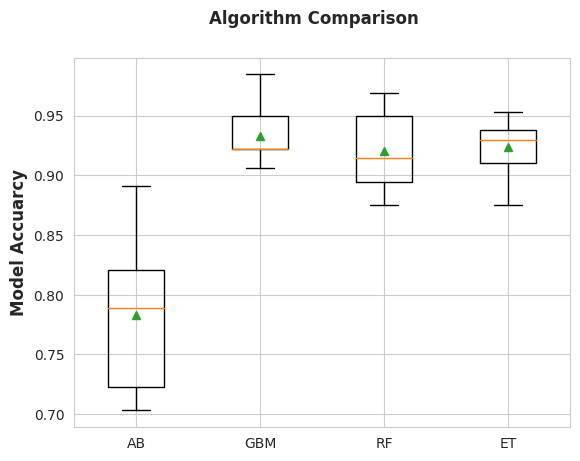

In [38]:
# d) Compare Algorithms
fig=plt.figure()
fig.suptitle('Algorithm Comparison',size=12, weight="bold")
ax = fig.add_subplot(111)
plt.boxplot(results_ens,labels=names_ens, showmeans=True)
ax.set_xticklabels(names_ens)
plt.ylabel("Model Accuarcy",size=12, weight="bold")
plt.show()

In [66]:
#Tune the best model AGB

param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingClassifier(random_state=None)
kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=14)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (round(grid_result.best_score_,2), grid_result.best_params_))

Best: 0.920000 using {'n_estimators': 100}


In [28]:
#Tune the best model RF

param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = RandomForestClassifier(random_state=None, n_jobs=14)
kfold = KFold(n_splits=num_folds, random_state=None)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (round(grid_result.best_score_,2), grid_result.best_params_))

Best: 0.920000 using {'n_estimators': 250}


In [67]:
#Finalize the model
final_GBM=GradientBoostingClassifier(random_state=seed, n_estimators=100)
final_GBM=final_GBM.fit(x_train, y_train)


In [68]:
# Make predictions on validation dataset

predictions= final_GBM.predict(x_val)
print(accuracy_score(y_val, predictions))

0.91875


In [44]:
#print the confusion matrix
print(confusion_matrix(y_val, predictions))

[[31  0  0  0]
 [ 1 39  4  0]
 [ 1  5 39  0]
 [ 0  1  0 39]]


In [69]:
#now let's print the classification report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           1       1.00      0.97      0.99        40
           2       0.91      1.00      0.95        31
           3       0.90      0.84      0.87        45
           4       0.87      0.89      0.88        44

    accuracy                           0.92       160
   macro avg       0.92      0.93      0.92       160
weighted avg       0.92      0.92      0.92       160



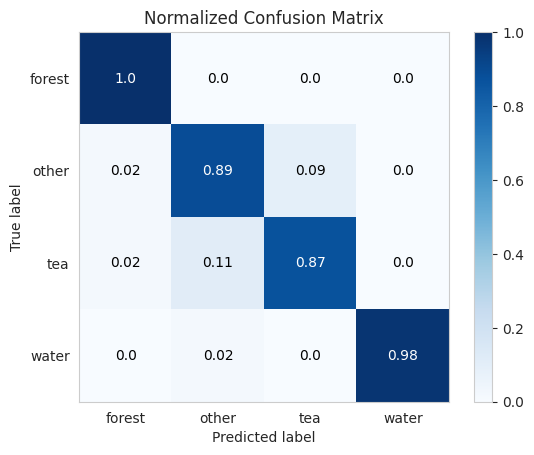

In [46]:
#we can now use the scikitplot to visualize the report
skplt.metrics.plot_confusion_matrix(y_val, predictions, normalize=True)
plt.show()

Feature: 0, Score: 0.04281
Feature: 1, Score: 0.02466
Feature: 2, Score: 0.00214
Feature: 3, Score: 0.04313
Feature: 4, Score: 0.27889
Feature: 5, Score: 0.01875
Feature: 6, Score: 0.13358
Feature: 7, Score: 0.01991
Feature: 8, Score: 0.20897
Feature: 9, Score: 0.21052
Feature: 10, Score: 0.01665


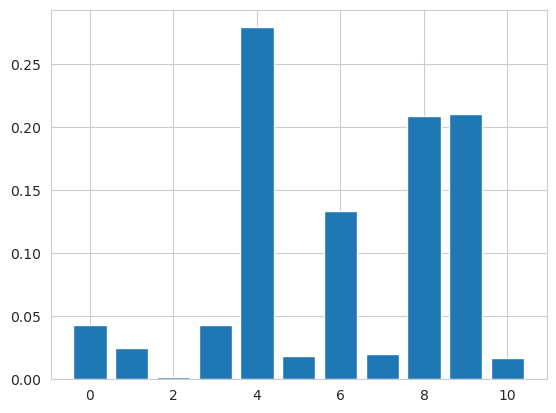

In [34]:
#plot variables importance
# get importance from GBM
importance = final_GBM.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


In [35]:
variables=list(x.columns)
variables

['band1',
 'band2',
 'band3',
 'band4',
 'band5',
 'band6',
 'band7',
 'band8',
 'band9',
 'band10',
 'band11']

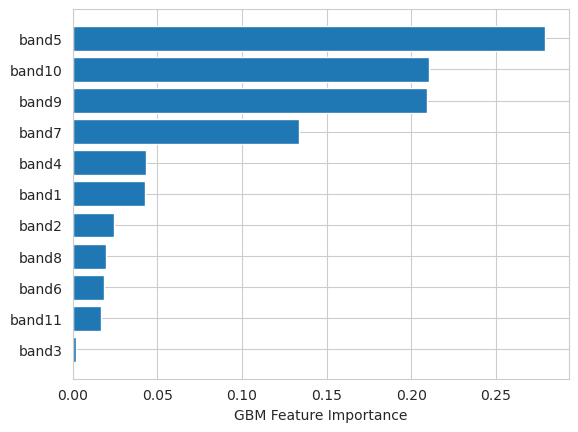

In [36]:
feature=x_train.columns
sorted_idx = final_GBM.feature_importances_.argsort()
plt.barh(feature[sorted_idx], final_GBM.feature_importances_[sorted_idx])
plt.xlabel("GBM Feature Importance");

In [70]:
#df_shp=gpd.read_file('/home/drdc/Documents/repos/pestsens/1_orginal/rwanda_points.shp')
import rasterio as rio
df_im=rio.open('/home/drdc/Documents/repos/pestsens/1_orginal/S2_srw.tif')
df_im.shape

(881, 654)

In [71]:
metadata = df_im.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

In [45]:
metadata

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 654,
 'height': 881,
 'count': 11,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 29.026632955055213,
        0.0, -8.983152841195215e-05, -2.396974672616119)}

In [213]:
x=df_im.coords["x"].values
y=df_im.coords["y"].values

In [214]:
len(y)

881

In [101]:
type(image_array)

numpy.ndarray

In [272]:
image_array.shape

(11, 881, 654)

In [72]:
# Convert the stacked image to a 2D NumPy array
array_2d = image_array.reshape(-1,image_array.shape[0])
array_2d.shape

(576174, 11)

In [75]:
# Make predictions on complete dataset

predictions_all= final_GBM.predict(array_2d)
type(predictions_all)

numpy.ndarray

In [ ]:
# predictions_all[predictions_all=="water"]=1
# predictions_all[predictions_all=="forest"]=2
# predictions_all[predictions_all=="tea"]=3
# predictions_all[predictions_all=="other"]=4

# predictions_all=predictions_all.astype(int)
# predictions_all

In [76]:
img_reshape = predictions_all.reshape(881, 654)

In [77]:
out_raster = rio.open('/home/drdc/Documents/repos/pestsens/2_processed/LC_pred.tif',
                                         'w',
                                          driver='GTiff',
                                          height=881,
                                          width=654,
                                          count=1, # output band number
                                          dtype='uint8', #output data type
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

array([1, 1, 3, ..., 1, 1, 1])

In [296]:
predictions_all.shape

(576174,)

In [301]:
predict_np=predictions_all.reshape(881,654)
print(predict_np[0:10])

[[1 1 3 ... 1 4 4]
 [1 1 1 ... 1 4 3]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 3 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [302]:
import xarray as xr
import numpy as np

# Assuming you have three NumPy arrays: data, latitudes, and longitudes

# Create a DataArray with the data array
data_array = xr.DataArray(predict_np)

# Create a DataArray for the latitude values
lat_array = xr.DataArray(y, dims=('latitude',), coords={'latitude': y})

# Create a DataArray for the longitude values
lon_array = xr.DataArray(x, dims=('longitude',), coords={'longitude': x})

# Combine the data, latitude, and longitude arrays into a single DataArray
spatial_array = xr.DataArray(data_array, coords={'latitude': lat_array, 'longitude': lon_array}, dims=('latitude', 'longitude'))


In [261]:
spatial_array.values

array([[1, 1, 3, ..., 1, 4, 4],
       [1, 1, 1, ..., 1, 4, 3],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=object)

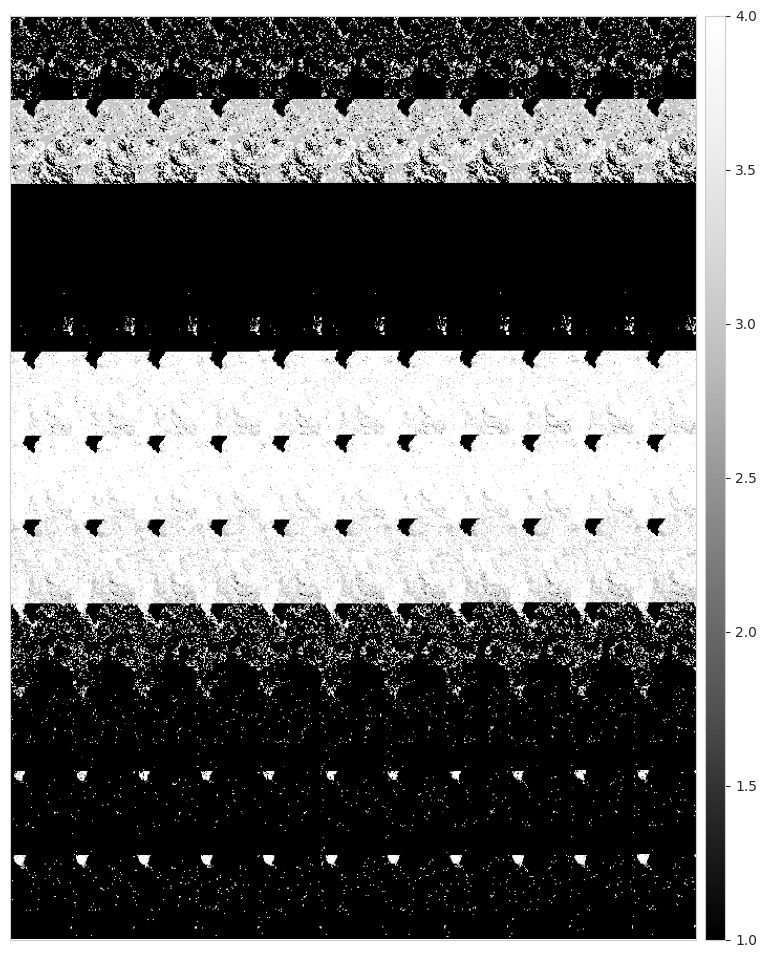

In [303]:

ep.plot_bands(spatial_array)
plt.show()

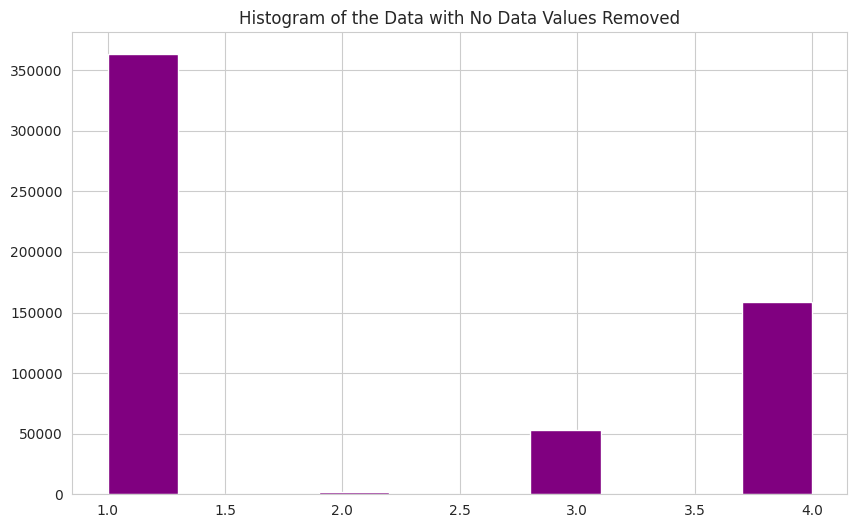

In [304]:
f, ax = plt.subplots(figsize=(10, 6))
spatial_array.plot.hist(color="purple"
                      )
ax.set_title("Histogram of the Data with No Data Values Removed")
plt.show()


In [238]:
type(spatial_array)

xarray.core.dataarray.DataArray

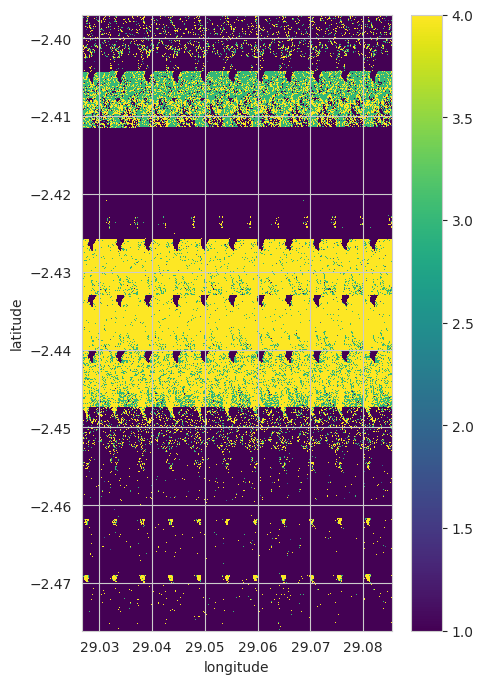

In [306]:
f, ax = plt.subplots(figsize=(5, 8))

spatial_array.plot.imshow(cmap="viridis",
                        ax=ax)

In [64]:
df_im.rio.resolution()

(8.983152841195215e-05, -8.983152841195215e-05)

In [83]:
src.height

881

In [246]:
spatial_array.values

array([[1, 1, 3, ..., 1, 4, 4],
       [1, 1, 1, ..., 1, 4, 3],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=object)

In [247]:
ep.plot_rgb(spatial_array.values,
            
            title="RGB Composite image - Sentinel2")
plt.show()

ValueError: Input needs to be 3 dimensions and in rasterio order with bands first

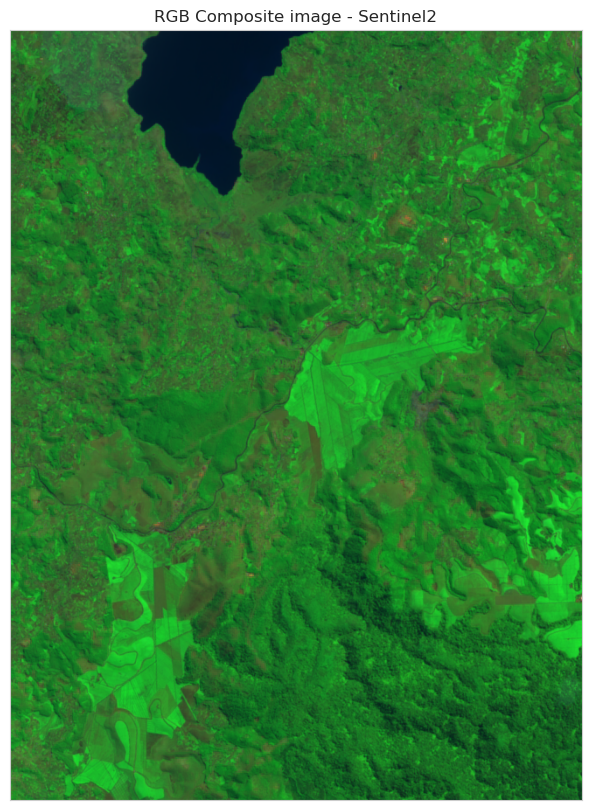

In [62]:
ep.plot_rgb(df_im.values,
            rgb=[0,4,9],
            title="RGB Composite image - Sentinel2")
plt.show()


In [103]:
t=dataset.transform

In [42]:
df1=raster_to_dataframe("/home/drdc/Documents/repos/pestsens/1_orginal/S2_srw.tif")
df1.head()

,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y
0,0.1743,0.2543,0.1011,0.1786,0.3251,0.3460,0.3085,0.2010,0.1622,0.1809,0.1985,29.026678,-2.39702
1,0.1743,0.2543,0.1011,0.1786,0.3330,0.3460,0.3085,0.2010,0.1702,0.1890,0.1999,29.026768,-2.39702
2,0.1928,0.2613,0.1011,0.1786,0.3044,0.3286,0.2948,0.2109,0.1871,0.1909,0.2010,29.026858,-2.39702
3,0.1928,0.2613,0.1011,0.1786,0.2935,0.3286,0.2948,0.2109,0.1953,0.1919,0.2036,29.026947,-2.39702
4,0.1783,0.2541,0.1012,0.1723,0.3059,0.3176,0.2865,0.1966,0.1825,0.1913,0.2021,29.027037,-2.39702


In [63]:
df1["class"]= final_GBM.predict(df1)
df1.head()

,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y,class
0,0.1743,0.2543,0.1011,0.1786,0.3251,0.3460,0.3085,0.2010,0.1622,0.1809,0.1985,29.026678,-2.39702,forest
1,0.1743,0.2543,0.1011,0.1786,0.3330,0.3460,0.3085,0.2010,0.1702,0.1890,0.1999,29.026768,-2.39702,forest
2,0.1928,0.2613,0.1011,0.1786,0.3044,0.3286,0.2948,0.2109,0.1871,0.1909,0.2010,29.026858,-2.39702,forest
3,0.1928,0.2613,0.1011,0.1786,0.2935,0.3286,0.2948,0.2109,0.1953,0.1919,0.2036,29.026947,-2.39702,forest
4,0.1783,0.2541,0.1012,0.1723,0.3059,0.3176,0.2865,0.1966,0.1825,0.1913,0.2021,29.027037,-2.39702,other


In [78]:
df1["class"].replace({"forest":1, "water":2, "tea":3, "other":4}, inplace=True)

df1.head()

,B12,B11,B10,B9,B8,B7,B6,B5,B4,B3,B2,x,y,class
0,0.1743,0.2543,0.1011,0.1786,0.3251,0.3460,0.3085,0.2010,0.1622,0.1809,0.1985,29.026678,-2.39702,1
1,0.1743,0.2543,0.1011,0.1786,0.3330,0.3460,0.3085,0.2010,0.1702,0.1890,0.1999,29.026768,-2.39702,1
2,0.1928,0.2613,0.1011,0.1786,0.3044,0.3286,0.2948,0.2109,0.1871,0.1909,0.2010,29.026858,-2.39702,1
3,0.1928,0.2613,0.1011,0.1786,0.2935,0.3286,0.2948,0.2109,0.1953,0.1919,0.2036,29.026947,-2.39702,1
4,0.1783,0.2541,0.1012,0.1723,0.3059,0.3176,0.2865,0.1966,0.1825,0.1913,0.2021,29.027037,-2.39702,4


In [105]:
df1.shape

(576174, 14)

In [118]:
  # Extract the column values as a numpy array
column_values = df1["class"].values
    
    # Reshape the column values into a 2D array
column_array = np.reshape(column_values, (df1.shape[0], 1))
column_array

array([[1],
       [1],
       [1],
       ...,
       [1],
       [2],
       [2]])

In [134]:
    # Create an empty raster array
raster_array = np.zeros((df1.shape[0], 1))
raster_array

576174

In [120]:
    # Copy the column values to the raster array
raster_array[:, 0] = column_array[:, 0]

In [133]:
raster_array

576174

In [131]:
import numpy as np
import pandas as pd
import rasterio

def dataframe_column_to_geotiff(df, column_name, output_file, crs, transform):

    """To use this function, you need to provide the following parameters:

    df: The pandas DataFrame containing the data.
    column_name: The name of the column in the DataFrame that you want to convert to a GeoTIFF raster.
    output_file: The path and filename for the output GeoTIFF raster file.
    crs: The coordinate reference system (CRS) for the raster. You can provide it as a string or an instance of rasterio.crs.CRS.
    transform: The affine transformation matrix for the raster. It defines the mapping between pixel coordinates and geographic coordinates. You can provide it as an instance of rasterio.transform.Affine.

Make sure to have the rasterio library installed (pip install rasterio) before running this code. Additionally, you may need to adjust the code depending on the specific structure and requirements of your DataFrame.
"""
    # Extract the column values as a numpy array
    column_values = df[column_name].values
    
    # Reshape the column values into a 2D array
    column_array = np.reshape(column_values, (df.shape[0], 1))
    
    # Create an empty raster array
    raster_array = np.zeros((df.shape[0], 1))
    
    # Copy the column values to the raster array
    raster_array[:, 0] = column_array[:, 0]
    
    # Create a rasterio dataset using the raster array
    with rasterio.open(
        output_file,
        'w',
        driver='GTiff',
        height=881,
        width=654,
        count=576174,
        dtype=raster_array.dtype,
        crs=crs,
        transform=t
    ) as dataset:
        dataset.write(raster_array,1)


In [ ]:
dataframe_column_to_geotiff(df1, "class","output1.tif", "EPSG:4326", t)

In [79]:
df1.to_csv("/home/drdc/Documents/repos/pestsens/2_processed/S2_pred.csv", index=False)

In [ ]:
# Example usage
ds=rasterize_csv_to_geotiff("/home/drdc/Documents/repos/pestsens/2_processed/S2_pred.csv",'/home/drdc/Documents/repos/pestsens/2_processed/class.tif', 'x', 'y', 'class',10, 0)

In [ ]:
ds=dataframe_to_geotiff(df1,'class.tif', "/home/drdc/Documents/repos/pestsens/1_orginal/S2_srw.tif", 'class')

In [172]:
import pandas as pd
import rasterio
from rasterio.transform import from_origin

In [168]:


def rasterize_csv_to_geotiff(csv_path, output_geotiff_path, x_col, y_col, value_col, pixel_size, nodata_value):
    # Read the CSV file using pandas
    df = pd.read_csv(csv_path)

    # Extract x, y, and value columns from the DataFrame
    x = df[x_col]
    y = df[y_col]
    values = df[value_col]

    # Determine the dimensions of the raster
    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)
    width = int((max_x - min_x) / pixel_size)
    height = int((max_y - min_y) / pixel_size)

    # Create the raster data array
    data = values.values.reshape(height, width)

    # Define the transformation parameters
    transform = from_origin(min_x, max_y, pixel_size, pixel_size)

    # Create the GeoTIFF file using rasterio
    with rasterio.open(
        output_geotiff_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=data.dtype,
        crs='EPSG:4326',
        transform=transform,
        nodata=nodata_value
    ) as dst:
        dst.write(data, 1)


